# 自动微分与反向传播算法

本实验使用MindSpore介绍了AI框架中的关键技术，包括自动微分和反向传播算法。结合课程学习，通过本实验可以了解自动微分的基本实现过程和反向传播算法流程，并且掌握使用MindSpore深度学习框架完成这些操作。

## 1、自动计算梯度

神经网络的参数主要通过梯度下降来进行优化，需要计算导数，而手动求导非常繁琐而且很容易出错。实际上，梯度计算可以由计算机自动实现，大幅度提高开发效率，目前主流的深度学习框架都具有自动计算梯度的功能。

自动计算梯度方法主要分为三类：**数值微分**、**符号微分**和**自动微分**。

### 1.1 数值微分

数值微分(Numerical Diferentiation)是用数值方法来计算函数$f(x)$的导数

函数$f(x)$的点$x$的导数定义为:

$$f^{'}(x)=\lim_{\Delta x \rightarrow 0}\frac{f(x+\Delta x)-f(x)}{\Delta x} \tag{1}$$

在实际应用，经常使用下面公式来计算梯度，可以减少截断误差。

$$f^{'}(x)=\lim_{\Delta x \rightarrow 0}\frac{f(x+\Delta x)-f(x-\Delta x)}{2\Delta x} \tag{2}$$

#### 1.1.1 数值微分实验

使用数值微分，并使用$f^{'}(x)=\lim_{\Delta x \rightarrow 0}\frac{f(x+\Delta x)-f(x)}{\Delta x}$计算下面函数在$x=5$的一阶导数：

$$f(x)=0.01x^{2}+0.1x \tag{3}$$

比较手动求导结果和数字计算结果，分析扰动$\Delta x$对结果的影响，并绘制$f(x)$在$x=5$处的切点、切线。

(0.20000099999917254, 0.2)

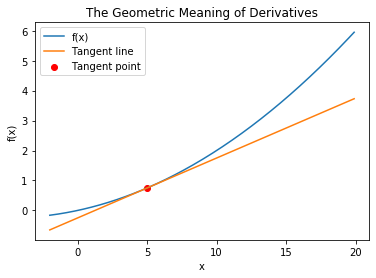

In [1]:
import matplotlib.pyplot as plt
import numpy as np

# 原函数
def function_1(x):
    return 0.01*x*x+0.1*x

# 原函数的导数
def function_diff(x):
    return 0.02*x+0.1

# 数值微分
def numerical_diff(f, x):
    h = 1e-4   # h越小越精确
    return (f(x+h)-f(x))/h

# 绘制图像
%matplotlib inline
x = np.arange(-2.0, 20.0, 0.1)
y = function_1(x)
plt.figure()
plt.xlabel("x")
plt.ylabel("f(x)")
plt.title("The Geometric Meaning of Derivatives")
plt.plot(x, y, label="f(x)")
plt.plot(x, 0.2*x-0.25, label="Tangent line")
plt.scatter(5, 0.75, color='r', label="Tangent point")
plt.legend()

dx_5_num = numerical_diff(function_1, 5)
dx_5_sym = function_diff(5)
dx_5_num, dx_5_sym  # 数值求解的导数与导数真值近似相等

#### 1.1.2 数值微分实验任务

利用$f^{'}(x)=\lim_{\Delta x \rightarrow 0}\frac{f(x+\Delta x)-f(x-\Delta x)}{2\Delta x}$计算使用数值微分计算$f(x)=0.01x^{2}+0.1x$在$x=5$的一阶导数。

### 1.2 符号微分

符号微分(Symbolic Differentiation)是一种基于**符号计算**的自动求导方法，一般不需要代入具体的值。符号计算的输入和输出都是数学表达式，如Mathematica、Maple、matlab、Maxima 等现代代数系统工具软件中都有符号微分。

### 1.3 自动微分

自动微分(Automatic Differentiation，AD)的处理对象是一个函数或一段程序，它是介于数值微分和符号微分之间的方法，采用**有向图计算**来求解微分值。当前比较流行的自动微分实现方式有三种，分别为**基本表达式**、**操作符重载**和**源代码变换**。

自动微分的计算过程：

<div align=center>
<img src="./images/自动微分计算流程图.png" width = "30%" height = "30%"/>
</div>

#### 1.3.1 自动微分实验介绍

以神经网络中常见的复合函数为例，采用**基本表达式**方法说明自动微分过程：

$$f(x;w,b)=\frac{1}{e^{-(wx+b)}+1} \tag{4}$$

> $x,w,b$均为标量

+ **构建计算图**

$$v_{0}=x \\ v_{1}=w \ast v_{0} \\ v_{2}=v_{1}+b \\ v_{3}= -1 \ast v_{2} \\ v_{4} = e^{v_{3}} \\ v_{5} = v_{4}+1 \\ v_{6}=\frac{1}{v_{5}} \tag{5}$$

构建计算图如下：

<div align=center>
<img src = "./images/普通感知机计算图.png" width="90%" height="90%" />
</div>

+ **构建导数表**

导数表：

<div align=center>
<img src = "./images/普通感知机导数表.png" width="50%" height="50%" />
</div>

+ **选择计算模式**

按照计算导数的顺序可以分为：正向模式和反向模式

**正向模式**：从变量出发，按计算图中计算方向相同方向来递归地计算导数。

**反向模式**：从最终函数出发，按计算图中计算方向的相反方向来递归地计算导数。

+ **计算过程**

1. 先进行前向传播，计算出所有中间变量$v_{0} \sim v_{6}$，并保存起来；

2. 选择自动微分计算模式（正向\反向），根据计算图和导数表计算每个节点的导数；

3. 将计算图中变量相关路径上的所有导数连乘起来，即：

$$\frac{\partial f(x;w,b)}{\partial x}=\frac{\partial f(x;w,b)}{\partial v_{6}}\frac{\partial v_{6}}{\partial v_{5}}\frac{\partial v_{5}}{\partial v_{4}}\frac{\partial v_{4}}{\partial v_{3}}\frac{\partial v_{3}}{\partial v_{2}}\frac{\partial v_{2}}{\partial v_{1}}\frac{\partial v_{1}}{\partial v_{0}}\frac{\partial v_{0}}{\partial v_{x}} \tag{6}$$

$$\frac{\partial f(x;w,b)}{\partial w}=\frac{\partial f(x;w,b)}{\partial v_{6}}\frac{\partial v_{6}}{\partial v_{5}}\frac{\partial v_{5}}{\partial v_{4}}\frac{\partial v_{4}}{\partial v_{3}}\frac{\partial v_{3}}{\partial v_{2}}\frac{\partial v_{2}}{\partial v_{1}}\frac{\partial v_{1}}{\partial w} \tag{7}$$

$$\frac{\partial f(x;w,b)}{\partial b}=\frac{\partial f(x;w,b)}{\partial v_{6}}\frac{\partial v_{6}}{\partial v_{5}}\frac{\partial v_{5}}{\partial v_{4}}\frac{\partial v_{4}}{\partial v_{3}}\frac{\partial v_{3}}{\partial v_{2}}\frac{\partial v_{2}}{\partial b} \tag{8}$$

> 如果参数有多个相关路径，那么将多个路径相乘的结果再相加即最终的导数。

接下来正式进行实验

#### 1.3.2 基本表达式实现自动微分

先从简单的$f=wx+b$开始，构建计算图如下：

<div align=center>
<img src="./images/线性运算计算图.png"  width="50%" height="50%" />
</div>

由计算图可知，上面式子可以分解为乘法和加法基本运算，我们可以定义乘法和加法类。

In [2]:
# 加法运算
class ADadd:

    def __init__(self):
        pass

    def forward(self, x, y):
        out = x + y
        return out

    def autoDiff(self, dout=1):
        dx = dout * 1
        dy = dout * 1
        return dx, dy


# 乘法运算
class ADmul:

    def __init__(self):
        self.x = None
        self.y = None

    def forward(self, x, y):
        self.x = x
        self.y = y
        out = x * y
        return out

    def autoDiff(self, dout=1):
        dx = dout * self.y
        dy = dout * self.x
        return dx, dy

##### 1.3.2.1 前向计算

按照计算图前向传播方向计算并保存中间结果。

In [3]:
# 计算x=0,w=1,b=0时，x,w,b的偏导数
# 创建加法和乘法对象
add = ADadd()
mul = ADmul()

# 初始参数
x = 0
w = 1
b = 0

# 前向计算
v0 = x
v1 = mul.forward(v0, w)
v2 = add.forward(v1, b)
print("v2: ", v2)

v2:  0


##### 1.3.2.2 正向自动微分

按照计算图正向传播方向进行递归计算导数。

+ 对$x$进行正向自动微分

设$v_{0}=x,v_{1}=w \ast v_{0},v_{2}=v_{1}+b$计算过程如下：

$$\frac{\partial v_{0}}{\partial x} =1  \\  \frac{\partial v_{1}}{\partial x}=\frac{\partial v_{0}}{\partial x}\frac{\partial v_{1}}{\partial v_{0}} = 1 \ast w  \\  \frac{\partial v_{2}}{\partial x}=\frac{\partial v_{0}}{\partial x}\frac{\partial v_{1}}{\partial v_{0}}\frac{\partial v_{2}}{\partial v_{1}} = 1 \ast w \ast 1 \tag{9}$$

In [4]:
# 正向自动微分，x
dv0 = 1
dv1 = mul.autoDiff(dv0)[0]
dv2 = add.autoDiff(dv1)[0]

dx = dv2
print("dx: ", dx)

dx:  1


+ 对$w$进行正向自动微分

设$v_{0}=x,v_{1}=w \ast v_{0},v_{2}=v_{1}+b$计算过程如下：

$$\frac{\partial v_{1}}{\partial w}=v_{0}  \\  \frac{\partial v_{2}}{\partial w}=\frac{\partial v_{1}}{\partial w}\frac{\partial v_{2}}{\partial v_{1}} = v_{0} \ast 1 \tag{10}$$

In [5]:
# 正向自动微分，w
dv1 = mul.autoDiff()[1]
dv2 = add.autoDiff(dv1)[0]

dw = dv2
print("dw: ", dw)

dw:  0


+ 对$b$进行正向自动微分

设$v_{0}=x,v_{1}=w \ast v_{0},v_{2}=v_{1}+b$计算过程如下：

$$\frac{\partial v_{2}}{\partial b}=1 \tag{11}$$

In [6]:
# 正向自动微分，b
dv2 = add.autoDiff()[1]

db = dv2
print("db: ", db)

db:  1


##### 1.3.2.3 反向自动微分

按照计算图前向传播的反方向进行递归计算导数。我们可以观察上面的正向自动微分过程，当输入数量大于输出数量时，需要多次进行多次正向自动微分过程才能求得所有变量的微分。这种情况，特别是输出为一个标量时，用反向自动微分效果会更好。

设$v_{0}=x,v_{1}=w \ast v_{0},v_{2}=v_{1}+b$计算过程如下：

$$\frac{\partial v_{2}}{\partial v_{1}} =1 , \frac{\partial v_{2}}{\partial b} =1 \\  \frac{\partial v_{2}}{\partial v_{0}}=\frac{\partial v_{2}}{\partial v_{1}} \frac{\partial v_{1}}{\partial v_{0}} = 1 \ast w , \frac{\partial v_{2}}{\partial w} =\frac{\partial v_{2}}{\partial v_{1}} \frac{\partial v_{1}}{\partial w}=1 \ast v_{0} \\  \frac{\partial v_{2}}{\partial x}=\frac{\partial v_{2}}{\partial v_{1}}\frac{\partial v_{1}}{\partial v_{0}}\frac{\partial v_{0}}{\partial x} = 1 \ast w \ast 1 \tag{12}$$

可以看到，进行一次反向计算就能够求出所有变量的微分。

In [7]:
dv2v1, db = add.autoDiff()
dv2v0, dw = mul.autoDiff(dv2v1)
dx = dv2v0

print("dx:  ", dx)
print("dw:  ", dw)
print("db:  ", db)

dx:   1
dw:   0
db:   1


#### 1.3.4 自动微分实验任务

+ 1. 采用实现除法运算和指数运算$e^{x}$，命名为ADdiv和ADexp

+ 2. 完成下面两个实验任务：

    + （1）利用基本表达式方法编码实现$sigmoid(x)$函数在$x=0$处的导数；
    + （2）若将$sigmoid(x)$当成一个基本操作，仿照基本操作的定义方式实现，命名为ADsigmoid

$$sigmoid(x)=\frac{1}{e^{-x}+1} \\ sigmoid^{'}(x)=sigmoid(x)(1-sigmoid(x))=-\frac{e^{-x}}{(e^{-x}+1)^{2}} \\ sigmoid^{'}(0)= 0.5 \tag{13}$$

+ 3. 利用上面的所提到内容，选择合适的自动微分计算方式编码实现下面的复合函数$x=0,w=1,b=1$的导数计算：

$$f(x;w,b)=\frac{1}{e^{-(wx+b)}+1} \tag{14}$$

### 1.4 MindSpore实现自动微分

MindSpore使用`ops.GradOperation`计算一阶导数，`ops.GradOperation`属性如下：

+ `get_all`：是否对输入参数进行求导，默认值为False。

+ `get_by_list`：是否对权重参数进行求导，默认值为False。

+ `sens_param`：是否对网络的输出值做缩放以改变最终梯度，默认值为False。

本实验使用MindSpore中的`ops.GradOperation`对函数 $f(x)=wx+b$ 求一阶导数。

#### 1.4.1 对输入求一阶导

对输入求导前需要先定义公式：

$$f(x)=wx+b \tag{21}$$

下面示例代码是公式(21)的表达，由于MindSpore采用函数式编程，因此所有计算公式表达都采用函数进行表示。

In [8]:
import numpy as np
import mindspore.nn as nn
from mindspore import Parameter, Tensor


class Net(nn.Cell):
    def __init__(self):
        super(Net, self).__init__()
        self.w = Parameter(np.array([6.0]), name='w')
        self.b = Parameter(np.array([1.0]), name='b')

    def construct(self, x):
        f = self.w * x + self.b
        return f

然后定义求导类`GradNet`，类的`__init__`函数中定义需要求导的网络`self.net`和`ops.GradOperation`操作，类的`construct`函数中对`self.net`的输入进行求导。其对应MindSpore内部会产生如下公式(22)：

$$f^{'}(x)=w \tag{22}$$

In [9]:
from mindspore import dtype as mstype
import mindspore.ops as ops


class GradNet(nn.Cell):
    def __init__(self, net):
        super(GradNet, self).__init__()
        self.net = net
        self.grad_op = ops.GradOperation()

    def construct(self, x):
        gradient_function = self.grad_op(self.net)
        return gradient_function(x)

前面定义的权重参数w=6，b=1，即：

$$f(x)=wx+b=6*x+1 \tag{23}$$

对上式进行求导，有：

$$f^{'}(x)=w=6 \tag{24}$$

In [10]:
x = Tensor([100], dtype=mstype.float32)
output = GradNet(Net())(x)

print(output)

[6.]


MindSpore计算一阶导数方法`ops.GradOperation(get_all=False, get_by_list=False, sens_param=False)`，其中`get_all`为`False`时，只会对第一个输入求导，为`True`时，会对所有输入求导。

#### 1.4.2 对权重求一阶导

对权重参数求一阶导，需要将`ops.GradOperation`中的`get_by_list`设置为`True`。

In [11]:
from mindspore import ParameterTuple


class GradNet(nn.Cell):
    def __init__(self, net):
        super(GradNet, self).__init__()
        self.net = net
        self.params = ParameterTuple(net.trainable_params())
        self.grad_op = ops.GradOperation(get_by_list=True)  # 设置对权重参数进行一阶求导

    def construct(self, x):
        gradient_function = self.grad_op(self.net, self.params)
        return gradient_function(x)

接下来，调用GradNet类对函数进行求导：

In [12]:
# 对函数进行求导计算
x = Tensor([100], dtype=mstype.float32)
fx = GradNet(Net())(x)

# 打印结果
print(f"wgrad: {fx[0]}\nbgrad: {fx[1]}")

wgrad: [100.]
bgrad: [1.]


若某些权重不需要进行求导，则在定义求导网络时，相应的权重参数声明定义的时候，将其属性`requires_grad`需设置为`False`。

In [13]:
class Net(nn.Cell):
    def __init__(self):
        super(Net, self).__init__()
        self.w = Parameter(Tensor(np.array([6], np.float32)), name='w')
        self.b = Parameter(Tensor(np.array([1.0], np.float32)), name='b', requires_grad=False)

    def construct(self, x):
        out = x * self.w + self.b
        return out


class GradNet(nn.Cell):
    def __init__(self, net):
        super(GradNet, self).__init__()
        self.net = net
        self.params = ParameterTuple(net.trainable_params())
        self.grad_op = ops.GradOperation(get_by_list=True)

    def construct(self, x):
        gradient_function = self.grad_op(self.net, self.params)
        return gradient_function(x)


# 构建求导网络
x = Tensor([5], dtype=mstype.float32)
fw = GradNet(Net())(x)

print(fw)

(Tensor(shape=[1], dtype=Float32, value= [ 5.00000000e+00]),)


#### 1.4.3 梯度值缩放

通过`sens_param`参数对网络的梯度做缩放以改变最终梯度。首先将`ops.GradOperation`中的`sens_param`设置为`True`，并确定缩放指数，其维度与输出维度保持一致。

In [14]:
class GradNet(nn.Cell):
    def __init__(self, net):
        super(GradNet, self).__init__()
        self.net = net
        # 求导操作
        self.grad_op = ops.GradOperation(sens_param=True)
        # 缩放指数
        self.grad_wrt_output = Tensor([0.1], dtype=mstype.float32)

    def construct(self, x):
        gradient_function = self.grad_op(self.net)
        return gradient_function(x, self.grad_wrt_output)


x = Tensor([6], dtype=mstype.float32)
output = GradNet(Net())(x)

print(output)

[0.6]


#### 1.4.4 停止计算梯度

使用`ops.stop_gradient`可以停止计算梯度，示例如下：

In [15]:
from mindspore.ops import stop_gradient


class Net(nn.Cell):
    def __init__(self):
        super(Net, self).__init__()
        self.w = Parameter(Tensor(np.array([6], np.float32)), name='w')
        self.b = Parameter(Tensor(np.array([1.0], np.float32)), name='b')

    def construct(self, x):
        out = x * self.w + self.b
        # 停止梯度更新，out对梯度计算无贡献
        out = stop_gradient(out)
        return out


class GradNet(nn.Cell):
    def __init__(self, net):
        super(GradNet, self).__init__()
        self.net = net
        self.params = ParameterTuple(net.trainable_params())
        self.grad_op = ops.GradOperation(get_by_list=True)

    def construct(self, x):
        gradient_function = self.grad_op(self.net, self.params)
        return gradient_function(x)


x = Tensor([100], dtype=mstype.float32)
output = GradNet(Net())(x)

print(f"wgrad: {output[0]}\nbgrad: {output[1]}")

wgrad: [0.]
bgrad: [0.]


## 2、误差反向传播算法

误差反向传播(error BackPropagation，BP)是1986年由Rumelhart和McClelland为首的科学家提出的概念，由该思想演化的误差反向传播算法系统地解决了多层神经网络隐含层连接权学习问题，它是迄今最成功的神经网络学习算法。现实任务中使用神经网络时，一般会使用梯度下降法进行参数学习，常使用误差反向传播来高效地计算梯度。下面就以前馈神经网络为例，介绍误差反向传播算法。

以人工神经网络为例，误差反向传播算法，在实际训练中的流程图：

<div align=center>
    <img src="./images/误差反向传播算法流程图.png"  width="30%" height="30%" />
</div>

在实际训练中可以用下面的伪代码表示：

<div align=center>
    <img src="./images/BP伪代码.png"  width="70%" height="70%" />
</div>

### 2.1 非线性拟合实验

经过前面的学习我们知道，人工神经网络能够以任意精度逼近任意连续非线性函数，接下来我们将使用人工神经网络拟合非线性函数$y=5sin(x)+3$，以此来熟悉误差反向传播算法的流程。

#### 2.1.1 处理数据集

在本实验中，需要生成数据集并进行可视化，然后定义加载数据集的函数，用于训练中加载数据集。

##### 2.1.1.1 生成数据集

定义数据集生成函数`get_data` ，生成训练数据集和验证数据集。

由于拟合的是非线性数据，假定要拟合的目标函数为：$y=5sin(x)+3$，那么我们需要的训练数据集应随机分布于函数周边，这里采用了$y=5sin(x)+3+noise$的方式生成，其中noise为遵循标准正态分布规律的随机数值。

In [16]:
import numpy as np


def get_data(num, w=5.0, b=3.0):
    for _ in range(num):
        x = np.random.uniform(-10.0, 10.0)
        noise = np.random.normal(0, 1)
        y = np.sin(x) * w + b + noise
        yield np.array([x]).astype(np.float32), np.array([y]).astype(np.float32)

使用`get_data`生成100组验证数据，并可视化。

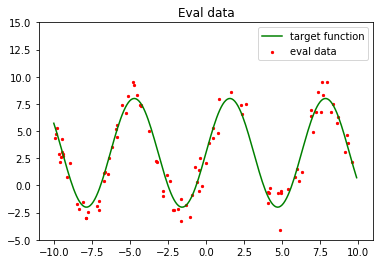

In [17]:
import matplotlib.pyplot as plt


train_data = list(get_data(100))
x_target_label = np.arange(-10, 10, 0.1)
y_target_label = np.sin(x_target_label) * 5.0 + 3.0
x_eval_label, y_eval_label = zip(*train_data)

x_eval = np.array(list(x_eval_label))
y_eval = np.array(list(y_eval_label))

plt.axis([-11, 11, -5, 15])
plt.scatter(x_eval, y_eval, color="red", s=5, label="eval data")
plt.plot(x_target_label, y_target_label, color="green", label="target function")
plt.title("Eval data")
plt.legend()
plt.show()

##### 2.1.1.2 加载数据集

加载`get_data`函数所产生的数据集到系统内存里面，并进行基本的数据处理操作。

+ `ds.GeneratorDataset`：将生成的数据转换为MindSpore的数据集，并且将生成的数据的x，y值存入到`data`和`label`的数组中。

+ `batch`：将`batch_size`个数据组合成一个batch。

+ `repeat`：将数据集数量倍增。

In [18]:
from mindspore import dataset as ds


def create_dataset(num_data, batch_size=16, repeat_size=1):
    input_data = ds.GeneratorDataset(list(get_data(num_data)), column_names=['data', 'label'])
    input_data = input_data.batch(batch_size, drop_remainder=True)
    input_data = input_data.repeat(repeat_size)
    return input_data

使用数据集增强函数生成训练数据，通过定义的`create_dataset`将生成的32000个数据增强为2000组shape为16x1的数据集。

In [19]:
data_number = 32000
batch_number = 16
repeat_number = 1

ds_train = create_dataset(data_number, batch_size=batch_number, repeat_size=repeat_number)
print("The dataset size of ds_train:", ds_train.get_dataset_size())
step_size = ds_train.get_dataset_size()
dict_datasets = next(ds_train.create_dict_iterator())

print(dict_datasets.keys())
print("The x label value shape:", dict_datasets["data"].shape)
print("The y label value shape:", dict_datasets["label"].shape)

The dataset size of ds_train: 2000
dict_keys(['data', 'label'])
The x label value shape: (16, 1)
The y label value shape: (16, 1)


#### 2.1.2 定义网络模型

`mindspore.nn`类是构建所有网络的基类，也是网络的基本单元。当用户需要自定义网络时，可以继承`nn.Cell`类，并重写`__init__`方法和`construct`方法。

`mindspore.ops`模块提供了基础算子的实现，`nn.Cell`模块实现了对基础算子的进一步封装，用户可以根据需要，灵活使用不同的算子。

如下示例使用`nn.Cell`构建一个3隐含层全连接网络，用于后续自定义内容的示例片段代码。在MindSpore中使用`nn.Dense`生成单个数据输入，单个数据输出的非线性函数模型：

$$y=5sin(x)+3 \tag{25}$$

并使用Normal算子随机初始化参数。

In [20]:
from mindspore import nn
from mindspore.common.initializer import Normal


class NonlinearNet(nn.Cell):
    def __init__(self):
        super(NonlinearNet, self).__init__()
        self.fc1 = nn.Dense(1, 100, Normal(), Normal())
        self.fc2 = nn.Dense(100, 100, Normal(), Normal())
        self.fc3 = nn.Dense(100, 1, Normal(), Normal())
        self.sigmoid = nn.Sigmoid()

    def construct(self, x):
        x = self.fc1(x)
        x = self.sigmoid(x)
        x = self.fc2(x)
        x = self.sigmoid(x)
        x = self.fc2(x)
        x = self.sigmoid(x)
        fx = self.fc3(x)
        return fx

训练前预测结果

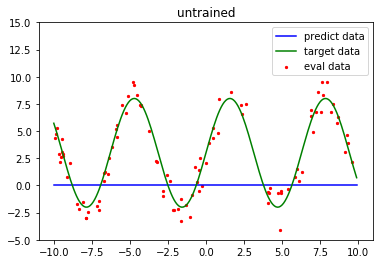

In [21]:
from mindspore import Tensor


net = NonlinearNet()  # 初始化非线性回归网络

x_model_label = np.arange(-10, 10, 0.1).astype(np.float32)
y_model_label = np.zeros_like(x_model_label)
for i in range(len(x_model_label)):
    y_model_label[i] = net(Tensor(np.expand_dims([x_model_label[i]], axis=0))).asnumpy()[0][0]

plt.axis([-11, 11, -5, 15])
plt.scatter(x_eval, y_eval, color="red", s=5, label="eval data")
plt.plot(x_model_label, y_model_label, color="blue", label="predict data")
plt.plot(x_target_label, y_target_label, color="green", label="target data")
plt.title("untrained")
plt.legend()
plt.show()

#### 2.1.3 损失函数和优化器

使用MSE损失函数和Adma优化器。

In [22]:
from mindspore import Tensor, Parameter
from mindspore import nn, ops
from mindspore import dtype as mstype


loss = nn.MSELoss()
optimizer_adam = nn.Adam(net.trainable_params())

#### 2.1.4 自定义训练流程

`mindspore.Model`提供了`train`和`eval`的接口方便用户在训练过程中使用，但此接口无法适用于所有场景，比如多数据多标签场景，在这些场景下用户需自行定义训练过程。

本节主要使用线性回归的例子来简单介绍自定义训练流程。首先定义损失网络，将前向网络与损失函数连接起来；然后定义训练流程，训练流程一般继承`nn.TrainOneStepCell`，`nn.TrainOneStepCell`封装了损失网络和优化器，用来实现反向传播网络以更新权重参数。

##### 定义损失网络

定义损失网络`MyWithLossCell`，将前向网络与损失函数连接起来。

In [23]:
class MyWithLossCell(nn.Cell):
    """定义损失网络"""

    def __init__(self, backbone, loss_fn):
        """实例化时传入前向网络和损失函数作为参数"""
        super(MyWithLossCell, self).__init__(auto_prefix=False)
        self.backbone = backbone
        self.loss_fn = loss_fn

    def construct(self, data, label):
        """连接前向网络和损失函数"""
        out = self.backbone(data)
        return self.loss_fn(out, label)

    def backbone_network(self):
        """要封装的骨干网络"""
        return self.backbone

##### 定义训练流程

定义训练流程`MyTrainStep`，该类继承`nn.TrainOneStepCell`，`nn.TrainOneStepCell`封装了损失网络和优化器，在执行训练时通过`ops.GradOperation`算子来进行梯度的获取，通过优化器来实现权重的更新。

In [24]:
class MyTrainStep(nn.TrainOneStepCell):
    """定义训练流程"""

    def __init__(self, network, optimizer):
        """参数初始化"""
        super(MyTrainStep, self).__init__(network, optimizer)
        self.grad = ops.GradOperation(get_by_list=True)

    def construct(self, data, label):
        """构建训练过程"""
        weights = self.weights
        loss = self.network(data, label)
        grads = self.grad(self.network, weights)(data, label)
        return loss, self.optimizer(grads)

下面定义绘图函数`plot_model_and_datasets`来绘制测试数据、目标函数和网络模型拟合函数，并查看损失值。

In [25]:
from IPython import display
import matplotlib.pyplot as plt
import time


def plot_model_and_datasets(net, data, loss):
    data_len = len(data)
    x1, y1 = zip(*data)
    x_eval = np.array(list(x1[i][0] for i in range(len(x1))))
    y_eval = np.array(list(y1[i][0] for i in range(len(y1))))
    x_target = np.arange(-10, 10, 0.1)
    y_target = np.sin(x_target) * 5 + 3
    x_predict = x_eval
    y_predict = np.zeros(data_len)
    for j in range(data_len):
        y_predict[j] = net(Tensor(np.expand_dims(x1[j], axis=0))).asnumpy()[0]

    plt.axis([-11, 11, -5, 15])
    plt.scatter(x_eval, y_eval, color="red", s=5, label="eval data")  # 原始数据
    plt.scatter(x_predict, y_predict, color="blue", s=5, label="predict data")  # 预测数据
    plt.plot(x_target, y_target, color="green", label="target data")  # 目标函数
    plt.title(f"Loss:{loss}")  # 打印损失值
    plt.legend()
    plt.show()
    time.sleep(1)
    display.clear_output(wait=True)

#### 2.1.5 执行训练

使用训练数据`ds_train`对训练网络`train_net`进行训练，并可视化训练过程。

Epoch:10,	 loss:1.062326


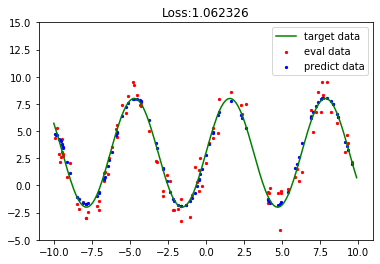

In [26]:
# 执行训练
loss_func = loss  # 损失函数
opt = optimizer_adam # 优化器
net_with_criterion = MyWithLossCell(net, loss_func)  # 构建损失网络
train_net = MyTrainStep(net_with_criterion, opt)  # 构建训练网络
epoch = 10 # 设置训练轮数

for n in range(epoch):
    for data in ds_train.create_dict_iterator():
        train_net(data['data'], data['label'])  # 执行训练，并更新权重
        train_loss = net_with_criterion(data['data'], data['label'])  # 计算损失值
    print("Epoch:{epoch_num},\t loss:{loss}".format(epoch_num=n+1, loss=train_loss))
    plot_model_and_datasets(net_with_criterion.backbone_network(), train_data, train_loss)

观察上面曲线的变化，如果效果不理想，可以重复执行上面的代码，继续训练。

## 3、小结

1. 自动计算梯度，包括数值微分、符号微分和自动微分；
2. 自动微分的手动实现和MindSpore实现；
3. 误差反向传播算法，使用非线性拟合进行演示。
